In [2]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Load brainspan data

In [4]:
df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')
cmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/columns_metadata.csv')

# Load component data

In [5]:
c1 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1.csv',
                    index_col=0)
c1 = pandas.pivot_table(data=c1,values=c1.columns[0],
                        index='gene_symbol')
c1.columns = ['expr']
c1 = c1.sort_values('expr',ascending=True)
c2 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C2.csv',
                    index_col=0)
c2 = pandas.pivot_table(data=c2,values=c2.columns[0],
                        index='gene_symbol')
c2.columns = ['expr']
c2 = c2.sort_values('expr',ascending=True)
c3 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C3.csv',
                    index_col=0)
c3 = pandas.pivot_table(data=c3,values=c3.columns[0],
                        index='gene_symbol')
c3.columns = ['expr']
c3 = c3.sort_values('expr',ascending=True)

In [6]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [7]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [6]:
df.shape

(52376, 525)

In [8]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

#### harmonize genes

In [9]:
shared = list(set(rmd.gene_symbol.values) & set(c1.index))
len(shared)

18503

In [10]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(18503, 525)

In [11]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,0.181220,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859


#### Get gene expression for each component and each columns

In [12]:
gdf = pandas.DataFrame(cmd,copy=True)

In [13]:
for i,col in enumerate(gxp.columns):
    gdf.loc[i,'C1_exp'] = np.dot(gxp[col],
                                 c1.loc[gxp.index].values)
    gdf.loc[i,'C2_exp'] = np.dot(gxp[col],
                                 c2.loc[gxp.index].values)
    gdf.loc[i,'C3_exp'] = np.dot(gxp[col],
                                 c3.loc[gxp.index].values)

In [26]:
#gdf.to_csv('~/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Brainspan.csv')

#### Prepare stuff for plots

In [14]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs','11 yrs']
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


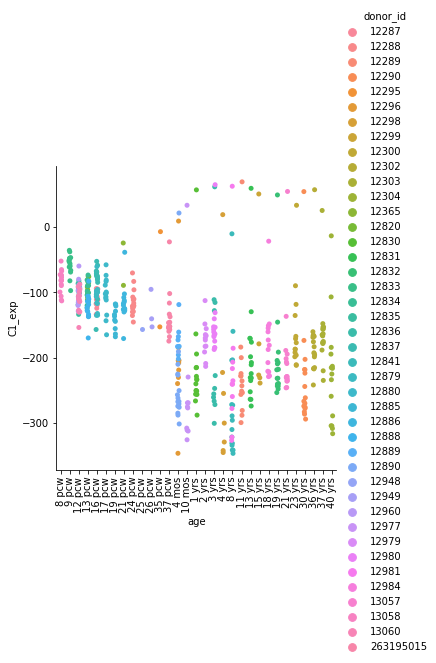

In [64]:
g = sns.catplot(x='age',y='C1_exp',data=gdf,order=order,
               hue='donor_id')
g.set_xticklabels(rotation=90)

In [66]:
list(zip(gdf.structure_acronym.unique(),
        gdf.structure_name.unique()))

[('Ocx', 'occipital neocortex'),
 ('M1C-S1C', 'primary motor-sensory cortex (samples)'),
 ('AMY', 'amygdaloid complex'),
 ('MGE', 'medial ganglionic eminence'),
 ('STC', 'posterior (caudal) superior temporal cortex (area 22c)'),
 ('URL', 'upper (rostral) rhombic lip'),
 ('CGE', 'caudal ganglionic eminence'),
 ('DTH', 'dorsal thalamus'),
 ('MFC', 'anterior (rostral) cingulate (medial prefrontal) cortex'),
 ('DFC', 'dorsolateral prefrontal cortex'),
 ('OFC', 'orbital frontal cortex'),
 ('LGE', 'lateral ganglionic eminence'),
 ('ITC', 'inferolateral temporal cortex (area TEv, area 20)'),
 ('HIP', 'hippocampus (hippocampal formation)'),
 ('VFC', 'ventrolateral prefrontal cortex'),
 ('PCx', 'parietal neocortex'),
 ('TCx', 'temporal neocortex'),
 ('A1C', 'primary auditory cortex (core)'),
 ('V1C', 'primary visual cortex (striate cortex, area V1/17)'),
 ('STR', 'striatum'),
 ('M1C', 'primary motor cortex (area M1, area 4)'),
 ('IPC', 'posteroventral (inferior) parietal cortex'),
 ('S1C', 'pri

In [15]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [4]:
gdf = pandas.read_csv('~/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Brainspan.csv',
                     index_col=0)

#### Plot

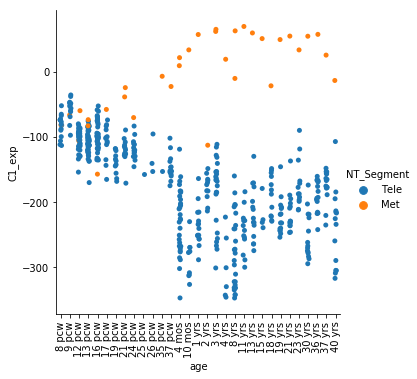

In [75]:
g = sns.catplot(x='age',y='C1_exp',data=gdf,order=order,
               hue='NT_Segment')
g.set_xticklabels(rotation=90)

In [16]:
gdf.columns

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'C1_exp', 'C2_exp', 'C3_exp',
       'MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period'],
      dtype='object')

In [30]:
as_order = ['fetal','infant','child','adolescent','adult']
ae_order = sorted(gdf.Age_Epoch.unique())
ap_order = gdf.Age_Period.unique()

In [ ]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

In [118]:
for x in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==x]['age_level'].values
    print('%s: min=%s, max=%s'%(x,np.min(levels),np.max(levels)))

fetal: min=0, max=12
infant: min=13, max=15
child: min=16, max=19
adolescent: min=20, max=24
adult: min=25, max=30


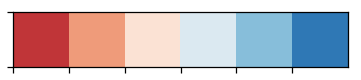

In [121]:
sns.palplot(sns.color_palette('RdBu'))

In [145]:
rbpal = [sns.color_palette('RdBu')[0],
                      sns.color_palette('RdBu')[-1]]

In [151]:
list(zip(range(len(gdf.age.unique())),gdf.age.unique()))

[(0, '8 pcw'),
 (1, '9 pcw'),
 (2, '12 pcw'),
 (3, '13 pcw'),
 (4, '16 pcw'),
 (5, '17 pcw'),
 (6, '19 pcw'),
 (7, '21 pcw'),
 (8, '24 pcw'),
 (9, '25 pcw'),
 (10, '26 pcw'),
 (11, '35 pcw'),
 (12, '37 pcw'),
 (13, '4 mos'),
 (14, '10 mos'),
 (15, '1 yrs'),
 (16, '2 yrs'),
 (17, '3 yrs'),
 (18, '4 yrs'),
 (19, '8 yrs'),
 (20, '11 yrs'),
 (21, '13 yrs'),
 (22, '15 yrs'),
 (23, '18 yrs'),
 (24, '19 yrs'),
 (25, '21 yrs'),
 (26, '23 yrs'),
 (27, '30 yrs'),
 (28, '36 yrs'),
 (29, '37 yrs'),
 (30, '40 yrs')]

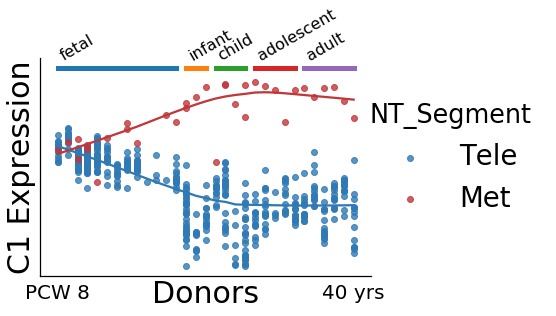

In [150]:
g = sns.lmplot(x='age_level',y='C1_exp'%comp,aspect=1.5,
               data=gdf[gdf['C1_exp'%comp]<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[100,100],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,110,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C1 Expression')
plt.yticks([])
plt.xlabel('Donors')
plt.xticks([])
plt.text(0,-420,'PCW 8',fontsize=20,ha='center')
plt.text(30,-420,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BS_Devel_C1.pdf',
   bbox_inches='tight')

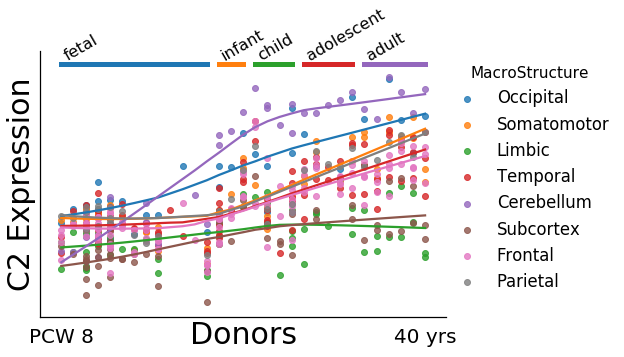

In [164]:
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='age_level',y='C2_exp'%comp,aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp'%comp]<1000)],
           hue='MacroStructure',lowess=True,
              palette='tab10')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[110,110],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,110,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
plt.text(0,-160,'PCW 8',fontsize=20,ha='center')
plt.text(30,-160,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BS_Devel_C2.pdf',
   bbox_inches='tight')

In [1]:
fdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/'
reg_types = ['MacroStructure', 'Sensorifugal']
for comp in ['C1','C2','C3']:
    for reg_type in reg_types:
        g = sns.lmplot(x='age_level',y='%s_exp'%comp,
                       data=gdf[gdf['%s_exp'%comp]<1000],
                   hue=reg_type,lowess=True)
        g.set_xticklabels(rotation=90)
        plt.xticks(ticks = range(len(gdf.age_level.unique())),
                  labels=order)
        #plt.savefig(os.path.join(fdir,'C%s_%s_AllAge.pdf'%(comp,reg_type)),
        #                         bbox_inches='tight')
        plt.show()

        for at,aord in age_types.items():
            sns.pointplot(x=at,y='%s_exp'%comp,
                          data=gdf[gdf['%s_exp'%comp]<1000],
                   hue=reg_type,order=aord,)
            sns.stripplot(x=at,y='%s_exp'%comp,alpha=0.3,
                          data=gdf[gdf['%s_exp'%comp]<1000],
                           hue=reg_type,order=aord)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.savefig(os.path.join(fdir,'C%s_%s_%s.pdf'%(comp,reg_type,at)),
                                 bbox_inches='tight') 
            plt.show()

NameError: name 'sns' is not defined

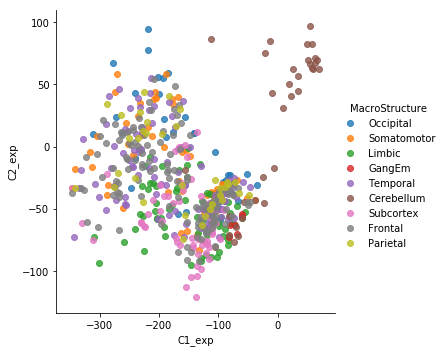

In [6]:
sns.lmplot('C1_exp','C2_exp',data=gdf,hue='MacroStructure',
           fit_reg=False)

In [31]:
%%capture
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
import numpy as np

# t = np.linspace(0,2*np.pi)
# x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([],[])

def animate(i):
    cat = gdf.Age_Epoch.unique()[i]
    t = gdf[gdf.Age_Epoch==cat]['C1_exp'].values
    x = gdf[gdf.Age_Epoch==cat]['C2_exp'].values
    l.set_data(t, x)

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                                         frames=len(gdf.Age_Epoch.unique()))

In [91]:
%%capture
# Set up the plot to be animated
# I'm using ax. here, but you could also just use plt.
fig, ax = plt.subplots()
ax.set_xlim(-400,100)
ax.set_xlabel('Component 1',fontsize=20)
ax.set_ylim(110, -150)
ax.set_ylabel('Component 2',fontsize=20)
#ax.set_title('Daily changes in pollution levels',fontsize=20)

# for i, txt in enumerate(data.sensor):
#     ax.annotate(txt, xy=(data.x[i], data.y[i]), textcoords='offset points', xytext=(10,10), fontsize=20, weight='bold')

# for convenience: define a function which prepares the data
def get_data(catn=0):
    cat = gdf.Age_Epoch.unique()[catn]
    x = gdf.loc[gdf.Age_Epoch==cat, 'C1_exp']
    y = gdf.loc[gdf.Age_Epoch==cat, 'C2_exp'] 
    #col = data.loc[(data.day ==day) & (data.sensor ==sensor_id), 'colour']  
    return x,y

# initialization function 
def init():
    x,y=get_data(catn=0)
    scat = ax.scatter(x,y,#c=col, 
                  s=10)
    # plot the first day (day=0) here:
#     for j in range(len(gdf.Age_Epoch.unique())):
#         x,y=get_data(catn=j)

    return scat

# animation function 
def animate(i): 
    plt.clf()
    #for j in range(len(gdf.Age_Epoch.unique())):        
    x,y=get_data(catn=i)
    # print(i,col)## use this to understand "where" we are
    scat = ax.scatter(x,y,
                      #c=col, 
                      s=100)

    # return plot object 
    return scat

# call the animator     
# you are iterating over day=i, so you only have 5 frames here
# also you cant use blit=True here
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(gdf.Age_Epoch.unique()),
                               interval=700,)

In [92]:
anim

<Figure size 432x288 with 0 Axes>

In [132]:
c1m = gdf.pivot_table(values='C1_exp',
                     columns='MacroStructure',
                     aggfunc=np.mean).values[0]
c1sd = gdf.pivot_table(values='C1_exp',
                     columns='MacroStructure',
                     aggfunc=np.std).values[0]
c2m = gdf.pivot_table(values='C2_exp',
                     columns='MacroStructure',
                     aggfunc=np.mean).values[0]
c2sd = gdf.pivot_table(values='C2_exp',
                     columns='MacroStructure',
                     aggfunc=np.std).values[0]

In [127]:
sns.color_palette('tab10')[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [135]:
colrs

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

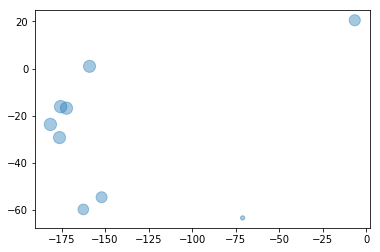

In [142]:
#colrs = sns.color_palette('tab10')
clr = ['Red' if x <4 else 'Black' for x in range(len(c1m))]
sns.regplot(c1m,c2m,fit_reg=False,
            scatter_kws={'s':c1sd*2,
                         'alpha':0.4,})

<Figure size 432x288 with 0 Axes>

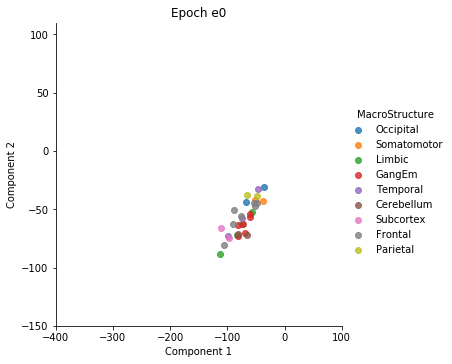

<Figure size 432x288 with 0 Axes>

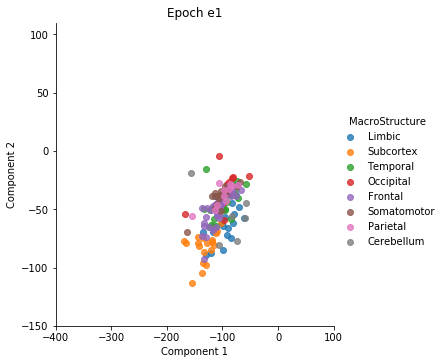

<Figure size 432x288 with 0 Axes>

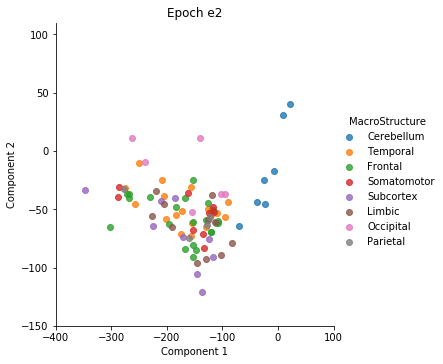

<Figure size 432x288 with 0 Axes>

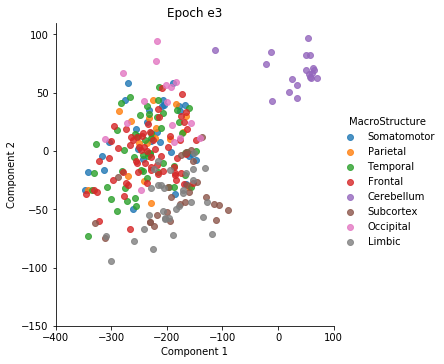

In [103]:
#my_dpi=96

# For each year:
for epoch in gdf.Age_Epoch.unique():
 
    # initialize a figure
    #fig = plt.figure(figsize=(680/my_dpi, 480/my_dpi), dpi=my_dpi)
    fig = plt.figure()
    
    # Change color with c and alpha. I map the color to the X axis value.
    sns.lmplot('C1_exp','C2_exp',data=gdf[gdf.Age_Epoch==epoch],
               hue='MacroStructure',fit_reg=False)

    # Add titles (main and on axis)
    #plt.yscale('log')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Epoch %s"%epoch )
    plt.xlim(-400,100)
    plt.ylim(-150,110)

# Save it
filename='Gapminder_step'+str(i)+'.png'
#plt.savefig(filename, dpi=96)
plt.gca()


In [ ]:
gtrack = pandas.DataFrame(gdf,copy=True)

In [12]:
from sklearn.preprocessing import StandardScaler

Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            513, 514, 516, 517, 518, 519, 520, 521, 522, 523],
           dtype='int64', length=490)

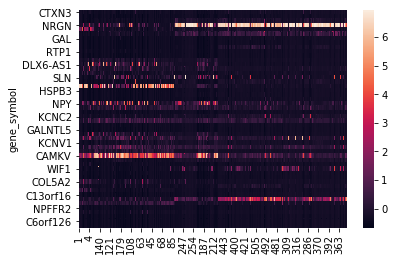

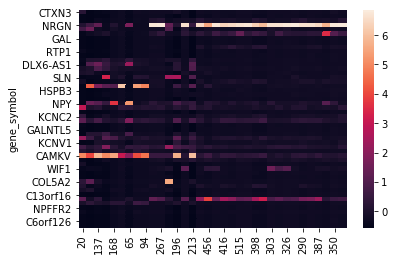

In [181]:
telelist = gdf[gdf.NT_Segment=='Tele'].index
metlist = gdf[gdf.NT_Segment=='Met'].index
jnk = pandas.DataFrame(gxp.reindex(c1.index).dropna()[:50],copy=True)
jnk = jnk[jnk.columns[gdf.Age_Epoch.sort_values().index]]
scaler = StandardScaler()
jnk = pandas.DataFrame(scaler.fit_transform(jnk.values),
                      index=jnk.index,columns=jnk.columns)
sns.heatmap(jnk[[x for x in jnk.columns if x in telelist]])
plt.show()
sns.heatmap(jnk[[x for x in jnk.columns if x in metlist]])
plt.show()

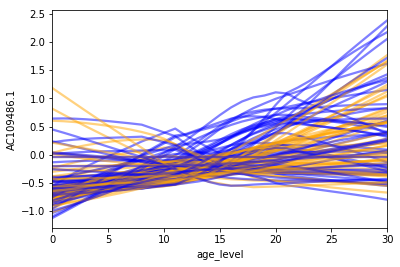

In [39]:
telelist = gdf[gdf.NT_Segment=='Tele'].index
metlist = gdf[gdf.NT_Segment=='Met'].index
plotr = pandas.DataFrame(gxp.reindex(c1.index).dropna()[:50],copy=True
                        ).T
scaler = StandardScaler()
plotr = pandas.DataFrame(scaler.fit_transform(plotr.values),
                      index=plotr.index,columns=plotr.columns)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period']:
    plotr.loc[:,col] = gdf.loc[:,col]
for i in plotr.columns[:50]:
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Tele'],
                     color='orange',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Met'],
                     color='blue',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
plt.show()

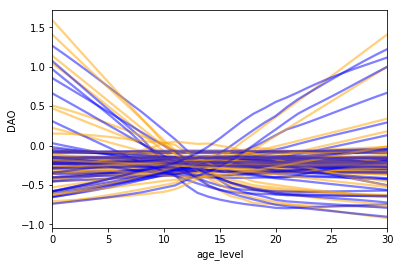

In [33]:
plotr = pandas.DataFrame(gxp.reindex(c1.index).dropna()[-50:],copy=True
                        ).T
scaler = StandardScaler()
plotr = pandas.DataFrame(scaler.fit_transform(plotr.values),
                      index=plotr.index,columns=plotr.columns)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period']:
    plotr.loc[:,col] = gdf.loc[:,col]
for i in plotr.columns[:50]:
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Tele'],
                     color='orange',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Met'],
                     color='blue',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
plt.show()

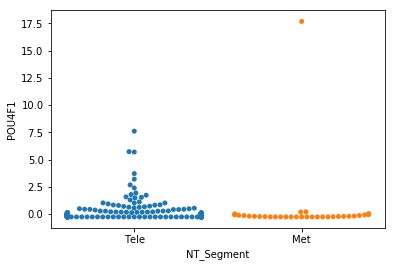

In [38]:
sns.swarmplot('NT_Segment',plotr.columns[1],data=plotr)

In [49]:
plotr[(plotr.NT_Segment=='Met') & (plotr.Age_Epoch=='e3')]

gene_symbol,CTXN3,TNNT2,GDA,NRGN,NR2E1,CCK,GAL,LAIR2,KIAA0748,RTP1,...,CSN1S1,C6orf126,AC109486.1,MacroStructure,Sensorifugal,NT_Segment,age_level,Age_Stage,Age_Epoch,Age_Period
276,0.313153,-0.453671,1.529698,1.807839,-0.155153,0.517411,0.984529,0.999518,0.192184,1.519307,...,-0.201199,-0.482288,-0.043727,Cerebellum,Not_Cortex,Met,14.0,infant,e3,p9
290,0.383706,-0.423195,2.662864,1.220641,-0.588784,0.379046,0.645271,-0.373643,0.594335,1.558565,...,-0.127006,0.940695,-0.043727,Cerebellum,Not_Cortex,Met,15.0,infant,e3,p9
303,-0.596499,-0.343999,-0.704682,-0.505991,-0.182427,-0.614016,-0.701340,-0.373643,-0.587265,-0.689580,...,-0.201199,0.301663,-0.043727,Cerebellum,Not_Cortex,Met,16.0,child,e3,p10
312,-0.531321,-0.466620,-0.277306,0.701533,1.062093,0.900750,1.713728,0.264149,-0.346606,-0.795618,...,-0.026453,-0.482288,-0.043727,Cerebellum,Not_Cortex,Met,17.0,child,e3,p10
326,-0.597279,-0.136232,-0.600577,-0.071071,0.613340,-0.306153,0.132873,3.313718,-0.407252,-0.162863,...,-0.201199,-0.482288,-0.043727,Cerebellum,Not_Cortex,Met,17.0,child,e3,p10
338,0.261829,-0.333428,0.456142,0.684143,-0.434955,6.329999,1.443621,0.881777,-0.011888,-0.302202,...,0.486735,0.560154,-0.043727,Cerebellum,Not_Cortex,Met,18.0,child,e3,p10
350,4.918779,0.709976,0.468686,2.840809,-0.515997,4.417602,3.701265,0.627003,1.512240,-0.305722,...,0.887242,7.254524,-0.043727,Cerebellum,Not_Cortex,Met,19.0,child,e3,p11
357,0.221938,-0.147089,1.311113,0.538707,-0.304700,0.547392,0.375959,0.698650,0.126426,1.318352,...,-0.161137,-0.482288,-0.043727,Cerebellum,Not_Cortex,Met,19.0,child,e3,p11
375,-0.325972,0.192568,0.396531,1.314092,-0.540118,0.589153,-0.561154,1.923283,1.301076,-0.420493,...,0.067263,-0.060329,-0.043727,Cerebellum,Not_Cortex,Met,20.0,adolescent,e3,p11
387,-0.054703,0.693630,0.405311,1.455369,-0.050539,0.652510,0.266889,0.318204,1.752174,1.665926,...,0.300822,-0.482288,-0.043727,Cerebellum,Not_Cortex,Met,21.0,adolescent,e3,p12


In [45]:
ts,ps = stats.ttest_ind(plotr[(plotr.NT_Segment=='Tele') &\
                              (plotr.Age_Epoch=='e3')
                             ][plotr.columns[:50]].values,
                       plotr[(plotr.NT_Segment=='Met') &\
                             (plotr.Age_Epoch=='e3')
                            ][plotr.columns[:50]].values)
multipletests(ps,method='fdr_bh')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([0.95519745, 0.78971904, 0.82666122, 0.77620654, 0.95519745,
        0.56793091, 0.78971904, 0.95519745, 0.77620654, 0.78971904,
        0.56793091, 0.78971904, 0.78971904, 0.91379985, 0.78971904,
        0.56793091, 0.56793091, 0.77620654, 0.56793091, 0.56793091,
        0.95519745, 0.78971904, 0.95519745, 0.78971904, 0.95519745,
        0.77620654, 0.91379985, 0.78971904, 0.78971904, 0.77620654,
        0.77620654, 0.77620654, 0.95519745, 0.95519745, 0.78971904,
        0.78971904, 0.95519745, 0.77620654, 0.77620654, 0.77620654,
        0.87177995, 0.82666122, 0.77620654, 0.79078903, 

# AHBA Comparison

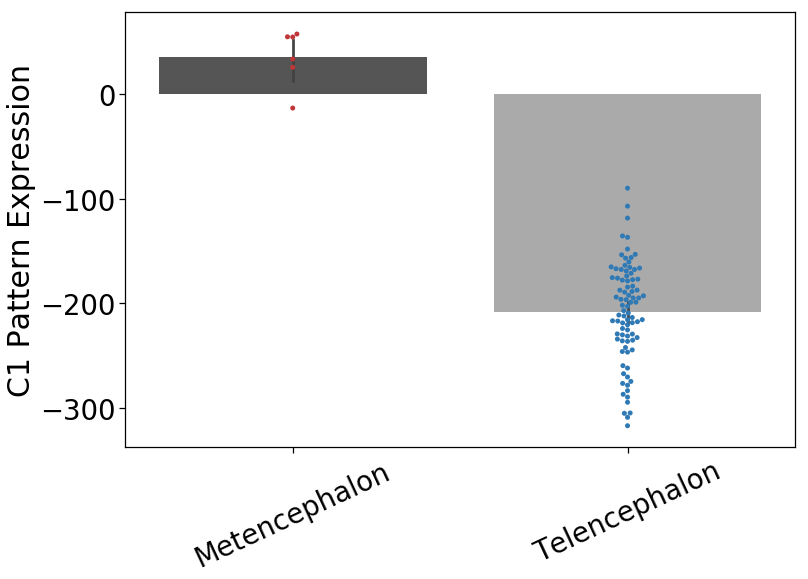

In [147]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Met','Tele']
sns.barplot(x='NT_Segment', y='C1_exp', 
            data=gdf[gdf.Age_Stage=='adult'],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='NT_Segment', y='C1_exp', 
              data=gdf[gdf.Age_Stage=='adult'], 
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C1 Pattern Expression')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C1.pdf',
           bbox_inches='tight')

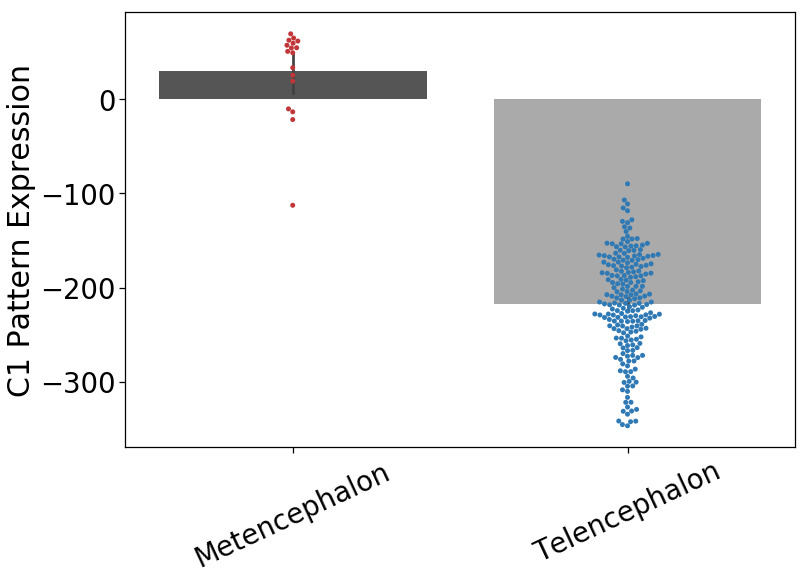

In [146]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Met','Tele']
sns.barplot(x='NT_Segment', y='C1_exp', 
            data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='NT_Segment', y='C1_exp', 
              data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C1 Pattern Expression')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C1-2.pdf',
           bbox_inches='tight')

In [11]:
abac2 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Thalamus', 'Limbic', 'Parietal', 'Frontal', 'Sensorimotor', 'Cerebellum', 'Striatum', 'Occipital', 'Temporal'}
missing: {'GangEm'}


In [12]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [13]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,20.491190,10.388806,0.205283,0.001726,Cerebellum
Frontal,-29.271514,2.720067,0.116883,0.003716,Frontal
Limbic,-54.584037,2.843349,-0.049497,0.006684,Limbic
Occipital,0.944763,7.002531,0.356953,0.005509,Occipital
Parietal,-16.797949,5.569316,0.254671,0.004321,Parietal


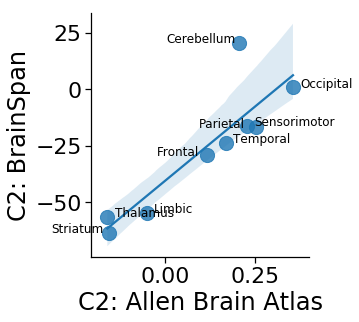

In [14]:
sns.set_context('notebook',font_scale=2)
sns.lmplot(x='ABA_mean',y='BS_mean',data=c2_comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
for i,div in enumerate(c2_comp.sort_values('ABA_mean').index):
    x = c2_comp.loc[div,'ABA_mean']
    #xsem = c2_comp.loc[div,'ABA_sem']
    y = c2_comp.loc[div,'BS_mean']
    #ysem = c2_comp.loc[div,'BS_sem']
    dist = len(div)*.02
    if i%2==0:
        plt.text(x+.02, y,div,{'size':12})
    else:
        plt.text(x-dist, y,div,{'size':12},
                 )
#     plt.plot([x-xsem,x+xsem],[y,y],c='k')
#     plt.plot([x,x],[y-ysem,y+ysem],c='k')
plt.xlabel('C2: Allen Brain Atlas')
plt.ylabel('C2: BrainSpan')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_C2.pdf',
           bbox_inches='tight')

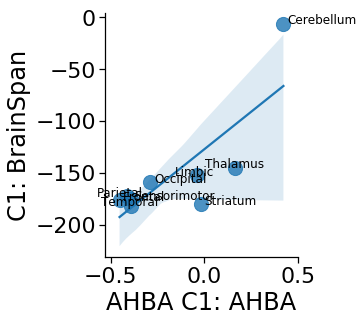

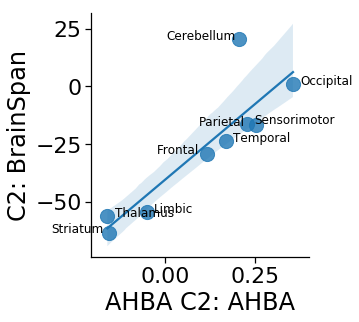

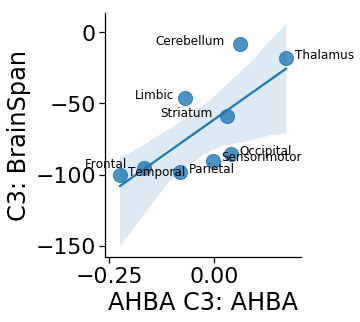

In [103]:
for i in range(1,4):
    aba = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_ABA_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['C%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('AHBA C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.show()

In [104]:
gdf.columns

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'C1_exp', 'C2_exp', 'C3_exp',
       'MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period', 'MacroStructure2'],
      dtype='object')

In [17]:
jnk = sns.color_palette('tab10')
c3pal = [jnk[1],jnk[0],jnk[2]]
#sns.palplot(c3pal)

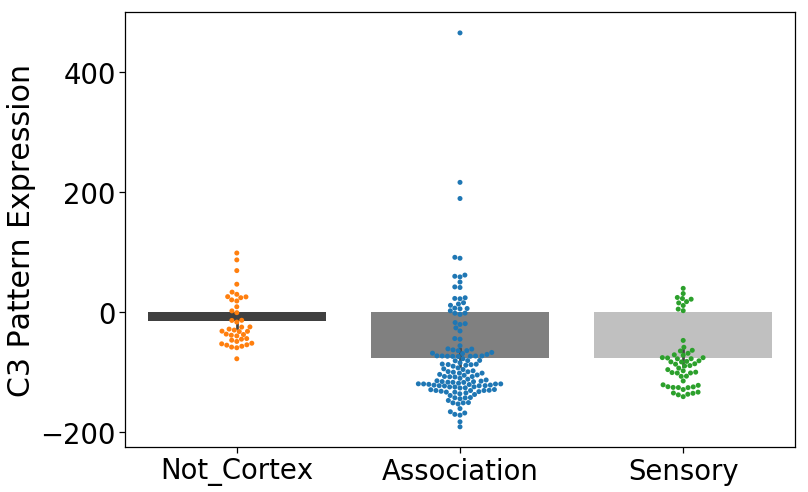

In [18]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not_Cortex','Association','Sensory']
sns.barplot(x='Sensorifugal', y='C3_exp', 
            data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Sensorifugal', y='C3_exp', 
              data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
              #hue='brain_divison',palette='RdBu'
              order = order, palette=c3pal
               )
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C3 Pattern Expression')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C3.pdf',
           bbox_inches='tight')

# Save for Bratislav's group

#### harmonized version

In [16]:
gxp.shape

(18503, 524)

In [17]:
rmd.shape

(47384, 5)

In [18]:
gxp.head()

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,0.181220,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859


In [21]:
new_rmd = pandas.DataFrame(rmd,copy=True)

In [22]:
new_rmd.index = new_rmd.gene_symbol.values
new_rmd = new_rmd.loc[gxp.index]

In [23]:
new_rmd.shape

(18503, 5)

In [24]:
new_rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata.csv',
              index=False)


In [31]:
new_rmd.head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
TSPAN6,1,7062.0,ENSG00000000003,TSPAN6,7105.0
TNMD,2,40735.0,ENSG00000000005,TNMD,64102.0
DPM1,3,8736.0,ENSG00000000419,DPM1,8813.0
SCYL3,4,36423.0,ENSG00000000457,SCYL3,57147.0
C1orf112,5,35021.0,ENSG00000000460,C1orf112,55732.0


In [29]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [36]:
gxp = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [37]:
gxp.columns = ['gene_symbol'] + list(range(len(gxp.columns)-1))

In [39]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv',
          index=False)

In [40]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')

,gene_symbol,0,1,2,3,4,5,6,7,8,...,514,515,516,517,518,519,520,521,522,523
0,TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
1,TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
2,DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
3,SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
4,C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
5,FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879
6,CFH,1.739810,1.631157,1.505638,0.184312,8.457812,0.824817,0.086144,0.104424,0.862773,...,1.667476,1.847824,2.738952,1.101955,1.154255,1.139357,2.328340,0.859632,3.075070,1.001095
7,FUCA2,10.093235,7.413745,6.844418,8.241343,8.193750,7.177653,9.689761,9.271467,11.968811,...,6.397180,7.710774,5.158115,3.639647,3.690433,3.727445,6.510842,7.756936,5.949388,5.762514
8,GCLC,2.632164,2.350074,2.091245,1.970610,2.780556,1.828027,2.176415,1.850360,2.753711,...,1.960404,0.921191,3.673846,4.520348,4.740486,4.534559,1.506123,2.928311,7.856748,3.138815
9,NFYA,24.845660,27.283269,26.226790,26.843769,29.272971,12.390913,27.550427,11.377583,20.556671,...,3.057490,3.941297,4.786867,7.405988,6.091779,6.380574,3.075336,3.484925,7.959293,4.179585


In [42]:
gdf.loc[:,'column_num'] = list(range(len(gdf)))

In [45]:
gdf.drop([x for x in gdf.columns if '_exp' in x],axis=1,inplace=True)


In [47]:
gdf.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/samples_metadata.csv',
          index=False)

#### original version

In [60]:
df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')

In [61]:
df.loc[:,0] = rmd.gene_symbol.values

In [65]:
df.columns = ['gene_symbol'] + list(range(len(cmd)))

In [68]:
rmd.loc[:,'row_num'] = range(len(rmd))

In [70]:
rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv',
          index=False)

In [73]:
df.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv',
         index=False)

In [75]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv'
               ).head()

,gene_symbol,0,1,2,3,4,5,6,7,8,...,514,515,516,517,518,519,520,521,522,523
0,TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
1,TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
2,DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
3,SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
4,C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859


In [76]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv'
               ).head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
0,0,7062.0,ENSG00000000003,TSPAN6,7105.0
1,1,40735.0,ENSG00000000005,TNMD,64102.0
2,2,8736.0,ENSG00000000419,DPM1,8813.0
3,3,36423.0,ENSG00000000457,SCYL3,57147.0
4,4,35021.0,ENSG00000000460,C1orf112,55732.0
